# Lösen der 1-D Diffusionsgleichung (explizit)

In [15]:
using Plots
using GeoModBox.HeatEquation.OneD

## Das Problem

Wir sind an der Änderung der Temperatur *T* mit der Zeit *t* interessiert, für eine bestimmte Anfangstemperatur $T_{0}[x,t_{0}]$ und Randbedingungen; z.B. eine Dikeintrusion in der Lithosphäre (mit *L* = 100 m; *W* = 5 m; *κ* = 10⁻⁶ m²/s).

<img src="../Figures/Exercise02_1.png" alt="drawing" width="350"/> <br>
**Abb. 1.** Sketch des geologischen Problems und des Profils der Anfangstemperaturbedingung. 

Wie lange würde es dauern, bis sich der Dike auf eine bestimmte Temperatur abgekühlt hat?

Zur Bestimmung der Dauer der Abkühlung müssen wir die Diffusionsgleichung der Temperatur lösen (parabolische PDG):

$$ 
\rho c_p \frac{\partial{T}}{\partial{t}} = \frac{\partial{}}{\partial{x}} \left( k\frac{\partial{T}}{\partial{x}} \right), 
$$

wobei *k* die thermische Leitfähigkeit, *T* die Temperatur und $\rho$ die Dichte ist. Durch Umformen (Annahme, dass die thermischen parameter konstant sind!) können wir die Gleichung durch die thermische Diffusivität $\kappa = \frac{k}{\rho c_p}$ ausdrücken: 

$$
\frac{\partial{T}}{\partial{t}} = \kappa \frac{\partial^2{T}}{\partial{x^2}}.
$$

## Die Lösung

### Finite Differenzen Approximation

Zur numerischen Lösung der Problems mit Hilfe von finiten Differenzen müssen wir zuerst ein numerisches Gitter erstellen (die Diskretisierung):

<img src="../Figures/Exercise02_2.png" alt="drawing" width="600"/> <br>
**Abb. 2.** Numerisches 1-D Gitter für die Diskretisierung der *PDG*.

Um die Diffusionsgleichung numerisch mit Hilfe der finiten Differenzen zu lösen müssen wir nun die *PDG* durch die Ausdrücke der finiten Differenzen umformulieren.

Vorwärts in der Zeit (FT):
$$
\frac{\partial{T}}{\partial{t}} \approx \frac{T_{i}^{n+1}-T_{i}^{n}}{t^{n+1}-t^{n}} = \frac{T_{i}^{n+1}-T_{i}^{n}}{\Delta t}
$$

Zentral im Raum (CS): 
$$
\frac{\partial^2{T}}{\partial{x^2}} \approx \frac{\frac{T_{i+1}^{n}-T_{i}^{n}}{\Delta x} - \frac{T_{i}^{n}-T_{i-1}^{n}}{\Delta x}}{\Delta x} =
\frac{T_{i+1}^{n} - 2T_{i}^{n} + T_{i-1}^{n}}{(\Delta x)^2}
$$

Damit ist, in expliziter Form, die Temperatur an jedem Punkt zum neuen Zeitpunkt gegeben durch:
$$
T_{i}^{n+1} = T_{i}^{n} + \kappa \Delta t \left( \frac{T_{i+1}^{n}-2T_{i}^{n}+T_{i-1}^{n}}{\Delta x^2} \right)
$$

### Parameterdefinitionen

Definieren wir für das Problem erst einmal bestimmte Parameter (physikalische Konstanten, numerische Domaine, Zeitparameter):

In [16]:
alternative =   1
# Physikalische Parameter ----------------------------------------------- #
L           =   100.0       # Laenge der Modeldomain [m]
Tdike       =   2500.0      # Temperatur des Dikes [C]
Trock       =   300.0       # Temperatur des Umgebungsgesteins [C]
κ           =   1.0e-6      # Thermische Diffusivitaet des Gesteins [m2/s]
W           =   5.0         # Breite des Dykes [m]
# ----------------------------------------------------------------------- #
# Numerische Parameter -------------------------------------------------- #
nc          =   100                 # Number of centroids 
Δx          =   L/(nc)              # Grid spacing 
xc          =   Δx/2:Δx:(L-Δx/2)    #   
ind         =   1:nc                # Indexes for internal points
# ----------------------------------------------------------------------- #
# Zeit Parameter -------------------------------------------------------- #
day         =   3600.0*24.0     # Sekunden pro Tag
Δt          =   0.9 * Δx^2 / (2.0 * κ)
nt          =   floor(Int, 200.0 * day/Δt ) 
time        =   0.0
# ----------------------------------------------------------------------- #

0.0

### Anfangsbedingungen

Zur Lösung unseres Problem, müssen wir noch die Anfangsbedingungen definieren. Dazu nehmen wir 300 °C für das Umgebungsgestein und 1200 °C für den Dike an. D.h. die Anfangstemperatur ist definiert durch:

$$
T \left(x < \left( \frac{L}{2} - W \right), x > \left( \frac{L}{2} + W \right), t = 0 \right) = 300, 
$$
$$
T \left(x > \left( \frac{L}{2} - W \right), x < \left( \frac{L}{2} + W \right), t = 0 \right) = 1200.
$$

Jetzt wollen wir erst einmal die Anfangsbedingung graphisch darstellen.

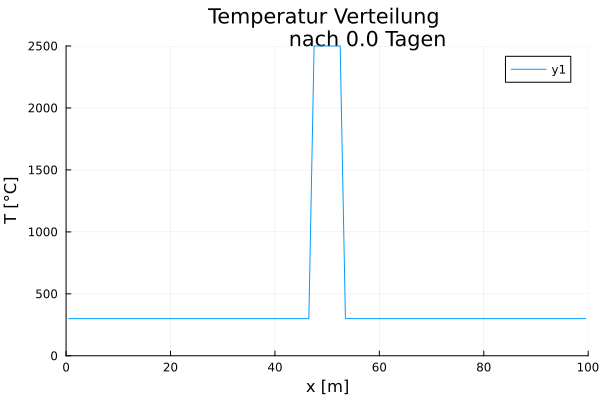

In [17]:
# Anfangsbedingungen; Temperaturprofil ---------------------------------- #
T       =   (T=zeros(nc), T_ex=zeros(nc+2))
T.T     .=  Trock                       # Temperatur des Umgebungsgesteins
@. T.T[abs(xc-L/2) <= W/2] =  Tdike       # Temperatur des Dikes

p = plot(xc, T.T, xlabel="x [m]", ylabel="T [°C]", 
            title="Temperatur Verteilung 
            nach $(round(time/day, digits=1)) Tagen", 
            xlim=(0,L), ylim=(0, Tdike))
display(p)
# ----------------------------------------------------------------------- #

### Randbedingungen

Da wir zentrale Gitterpunkte für die Temperatur verwenden, liegt kein Gitterpunkt direkt auf den Rändern (hingegen jeder Erwartung ist das allerdings ein Vorteil!). Zur Festlegung der Temperaturrandbedingungen müssen wir uns also der zusätzlichen *Ghost nodes* bediehnen (siehe Abbildung 2), d.h. wir bestimmen die Temperatur auf den *Ghost nodes* um die partielle Differentialgleichung der Temperatur auf dem **nächsten inneren** Gitterpunkt mit Hilfe der finiten Differenzen lösen zu können. Für eine konstante Temperaturbedingung and den Rändern (Dirichlet), können wir die Temperatur der *Ghost nodes* durch lineare Interpolation bestimmem, so dass: 

$$
T_{Ghost,W} = 2 T_{BC,W} + T[1]
$$
$$
T_{Ghost,E} = 2 T_{BC,E} + T[nc]
$$

Bei der Programmierung bediehnung wir uns eines Tricks und definieren die Temperatur auf den *Ghost nodes* später im Skript: 

In [18]:
# Randbedingungen ------------------------------------------------------- #
BC          =   (
                    type = (W=:Dirichlet, E=:Dirichlet),
                    #type = (W=:Neumann, E=:Neumann),
                    val = (W=:300.0,E=:300.0)
)
# ----------------------------------------------------------------------- #

(type = (W = :Dirichlet, E = :Dirichlet), val = (W = 300.0, E = 300.0))

### Visualisierung

Zur Visualisierung der Ergebnisse als eine Animation in einer GIF Datei, müssen noch der Ort und der Name der Datei festgelegt werden: 

In [19]:
# Animationssettings ---------------------------------------------------- #
path        =   string("./Results/")
anim        =   Plots.Animation(path, String[] )
filename    =   string("02_1D_explicit_",alternative)
save_fig    =   1
# ----------------------------------------------------------------------- #

1

### Zeitschleife

Numerisch können wir nun in einer Zeitschleife die *PDG* auf unterschiedliche Art und Weise lösen (Alternative I ist ausreichend; wer möchte, kann auch die Alternativen II und III lösen). Dabei wird für jeden Zeitschritt die Temperatur auf den *Ghost nodes* bestimmt durch die obigen Gleichungen.

In [20]:
# Time loop ------------------------------------------------------------- #
for n = 1:nt
    println("Zeitschritt: ",n,", Time: $(round(time/day, digits=1)) [d]")        

    if alternative == 1       
        # Alternative I ---
        # Einfache Programmierung der Gleichung in einer Schleife
        # Schleife über das Gitter (ohne die Randpunkte!)    
        T.T_ex[2:end-1]   = T.T    
        # Festlegen der Randbedingungen
        # West
        T.T_ex[1]    =   (BC.type.W==:Dirichlet) * (2 * BC.val.W - T.T_ex[2]) + 
                                (BC.type.W==:Neumann) * (T.T_ex[2] - BC.val.W*Δx)
        # East
        T.T_ex[end]  =   (BC.type.W==:Dirichlet) * (2 * BC.val.E - T.T_ex[nc+1]) +
                                (BC.type.W==:Neumann) * (T.T_ex[nc+1] + BC.val.E*Δx)
        for i = 1:nc
            # Berechnung der Temperatur am Punkt i zur neuen Zeit
            T.T[i]    =   T.T_ex[i+1] + κ * Δt * 
                                    (T.T_ex[i + 2] - 2.0 * T.T_ex[i+1] + T.T_ex[i]) / Δx^2
        end                
    elseif alternative == 2
        # Alternative II ---                         
        # Berechnung der Temperatur an den inneren Punkten zum neuen Zeitpunkt an
        T.T_ex[2:end-1]   = T.T
        # West
        T.T_ex[1]    =   (BC.type.W==:Dirichlet) * (2 * BC.val.W - T.T_ex[2]) + 
                                (BC.type.W==:Neumann) * (T.T_ex[2] - BC.val.W*Δx)
        # East
        T.T_ex[end]  =   (BC.type.W==:Dirichlet) * (2 * BC.val.E - T.T_ex[nc+1]) +
                                (BC.type.W==:Neumann) * (T.T_ex[nc+1] + BC.val.E*Δx)

        @. T.T[ind]  =   T.T_ex[ind+1] + κ * Δt * 
                                    (T.T_ex[ind + 2] - 2.0 * T.T_ex[ind+1] + T.T_ex[ind]) / Δx^2
    elseif alternative == 3    
        ForwardEuler1Dc!( T, κ, Δt, nc, Δx, BC )
    end
    # Calculate time ---
    time    =   time + Δt
    # Plot Lösung ---
    p = plot(xc, T.T, xlabel="x [m]", ylabel="T [°C]", 
            title="Temperatur Verteilung nach 
            $(round(time/day, digits=1)) Tagen", 
            xlim=(0,L),ylim=(0, Tdike))    
    if save_fig == 1
        Plots.frame(anim)
    else
        display(p)
    end
end

Zeitschritt: 1, Time: 0.0 [d]
Zeitschritt: 2, Time: 5.2 [d]
Zeitschritt: 3, Time: 10.4 [d]
Zeitschritt: 4, Time: 15.6 [d]
Zeitschritt: 5, Time: 20.8 [d]
Zeitschritt: 6, Time: 26.0 [d]
Zeitschritt: 7, Time: 31.3 [d]
Zeitschritt: 8, Time: 36.5 [d]
Zeitschritt: 9, Time: 41.7 [d]
Zeitschritt: 10, Time: 46.9 [d]
Zeitschritt: 11, Time: 52.1 [d]
Zeitschritt: 12, Time: 57.3 [d]
Zeitschritt: 13, Time: 62.5 [d]
Zeitschritt: 14, Time: 67.7 [d]
Zeitschritt: 15, Time: 72.9 [d]
Zeitschritt: 16, Time: 78.1 [d]
Zeitschritt: 17, Time: 83.3 [d]
Zeitschritt: 18, Time: 88.5 [d]
Zeitschritt: 19, Time: 93.8 [d]
Zeitschritt: 20, Time: 99.0 [d]
Zeitschritt: 21, Time: 104.2 [d]
Zeitschritt: 22, Time: 109.4 [d]
Zeitschritt: 23, Time: 114.6 [d]
Zeitschritt: 24, Time: 119.8 [d]
Zeitschritt: 25, Time: 125.0 [d]
Zeitschritt: 26, Time: 130.2 [d]
Zeitschritt: 27, Time: 135.4 [d]
Zeitschritt: 28, Time: 140.6 [d]
Zeitschritt: 29, Time: 145.8 [d]
Zeitschritt: 30, Time: 151.0 [d]
Zeitschritt: 31, Time: 156.3 [d]
Zeitschr

Nun müssen wir noch die Animation erstellen und speichern:

In [21]:
# Speicher Animation ---------------------------------------------------- #
if save_fig == 1
    # Write the frames to a GIF file
    Plots.gif(anim, string( path, filename, ".gif" ), fps = 15)
else
    display(p)
end
foreach(rm, filter(startswith(string(path,"00")), readdir(path,join=true)))
# ----------------------------------------------------------------------- #

┌ Info: Saved animation to /home/lfuchs/progs/src/julia/scripts/GeoModBox.jl/exercises/Correction/Results/02_1D_explicit_3.gif
└ @ Plots /home/lfuchs/.julia/packages/Plots/kLeqV/src/animation.jl:156
